# Part V: Compute persistence images and their PCA summary

Now that we have all the persistence diagrams for all the gene-cell combinations of interest, we need to compare them and say meaningful statistics from them.

To that end, the diagrams are:

1. density-normalized: a PD produced by a KDE with 10 transcripts has much lower birth-death values than a PD coming from a KDE with 1000 transcripts.
2. re-scaled so that the maximum death value is 16. The 16 value is arbitrary: it was simply chosen so that values are more easily readable. In fact, we explored if there were differences when considering 8, 16, 24, 32, 40, 48.
3. transformed to persistence images. We make sure to use the exact same transformer for all PDs
4. PCA is computed to finally summarize the resulting images

These steps can be done by looking at just one or several genes at a time, depending if we want to analyze how a particular gene's spatial distribution varies across different cell types or if we want to analyze how 2 or more genes possibly influence each other's spatial distribution in the same cell. 

In [1]:
import json
import functools
import os
import itertools
from importlib import reload

os.environ["OMP_NUM_THREADS"] = "1" # export OMP_NUM_THREADS=4
os.environ["OPENBLAS_NUM_THREADS"] = "1" # export OPENBLAS_NUM_THREADS=4 
os.environ["MKL_NUM_THREADS"] = "1" # export MKL_NUM_THREADS=6
os.environ["VECLIB_MAXIMUM_THREADS"] = "1" # export VECLIB_MAXIMUM_THREADS=4
os.environ["NUMEXPR_NUM_THREADS"] = "1" # export NUMEXPR_NUM_THREADS=6

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import persim
import utils
from sklearn import decomposition, preprocessing

In [3]:
exclude_nuclei = True
normtype = 'both'
level = 'sub'
fs = 12
dpi = 96
marker = ['D', '8', 's', '^', 'v', 'P', 'X', '*']
color = ['#56b4e9', '#f0e442', '#009e73', '#0072b2', '#d55e00', '#cc79a7', '#e69f00', '#e0e0e0', '#000000']
cmap = ['Blues_r', 'Wistia', 'Greens_r', 'BuPu_r', 'Oranges_r', 'RdPu_r']
seed = 42
ndims = 3
perms = [np.nonzero(p)[0] for p in itertools.product(range(2), repeat=ndims)][1:]

sample = 'D2'

ksrc = os.pardir + os.sep + 'kde' + os.sep + sample + os.sep
tsrc = os.pardir + os.sep + 'translocs' + os.sep + sample + os.sep
dst = os.pardir + os.sep + 'infected_focus_summer24' + os.sep + sample + os.sep
gsrc = os.pardir + os.sep + level + 'level' + os.sep + sample + os.sep

metacell = pd.read_csv(ksrc + sample + '_cells_metadata.csv', index_col = 'ndimage_cellID')
Cells = utils.get_range_cell_values(dst + 'infected_cells_ids.csv', metacell, startval=1)
Cells = np.setdiff1d( Cells, metacell[metacell['number_nuclei'] > 1].index)
    
if exclude_nuclei:
    ex_nuclei = ''
else:
    ex_nuclei = '_w_nucleus'

transcell = pd.read_csv(ksrc + sample + '_transcells_metadata' + ex_nuclei + '.csv', index_col='gene').rename(columns=int)
transcriptomes = np.asarray(transcell.index, dtype=str)
Genes = utils.get_range_gene_values(dst + 'genes_to_focus_infection' + ex_nuclei + '.csv', transcriptomes, startval=0)

- Choose whether to analyze one or various genes at a time

In [56]:
transcell.columns

Index([   1,    2,    3,    4,    5,    6,    7,    8,    9,   10,
       ...
       2928, 2929, 2930, 2931, 2932, 2933, 2934, 2935, 2936, 2937],
      dtype='int64', length=2937)

In [4]:
transfocus = transcell.loc[ np.atleast_1d( transcriptomes[Genes[ 0 ]]), Cells]
#transfocus = transcell.loc[ np.atleast_1d( transcriptomes[Genes[ :2 ]]), Cells]
ratios = utils.normalize_counts(transfocus, normtype)
if ratios is None:
    print('ERROR')
genes = '_-_'.join(sorted([ g.split('_')[-1] for g in ratios.index ]))
print(ratios.sum().sum(), 'Max ratio by {}:\t{:.2f}%'.format(normtype, 100*np.max(ratios) ) )
transfocus.sort_values(by=transfocus.index[0], axis=1)

1.0 Max ratio by both:	0.48%


,2430,1724,1335,1571,1933,2161,1143,1418,1673,2153,...,751,560,1757,326,677,1118,1722,2244,188,2288
gene,,,,,,,,,,,,,,,,,,,,,
GLYMA_17G195900,49,51,61,62,67,69,87,90,97,99,...,1885,1885,1984,2079,2161,2209,2229,2370,2397,3159


- Get all the previously computed persistence diagrams (load the JSON files)
- Density-normalize them
- Re-scale them so that values are much more interpretable. In this case, maximum death time is 16. The choice of 16 is arbitrary
- Transform the persistence diagrams into lifetime diagrams

Ultimately, we have a dictionary of dictionaries of dictionaries of lists:

```
diags[gene_name][cell_id][dimension_k]
```

If a gene has transcript presence in a given cell, then no persistence diagram file will be present. Which in turn means that the `diags[gene_name]` dictionary will have no key for that cell ID.

In [6]:
print((ratios > 0).sum(axis = 1))
PP = 6
stepsize = 3
bw = 25
SCALE = 16

foo = '{}{}' + os.sep + '{}_-_{}_p{}_s{}_bw{}_c{:06d}.json'
jsonfiles = dict()

for t in transfocus.index:
    jsonfiles[t] = [ foo.format(gsrc, t, t, level, PP, stepsize, bw, Cells[i]) for i in range(ratios.shape[1]) ]

orig_diags = utils.get_diagrams(jsonfiles, ndims, remove_inf=True)
nzcumsum = np.hstack(([0], np.cumsum(list(map(len, iter(orig_diags.values()))))))
bsummary = pd.DataFrame(index=range(nzcumsum[-1]), columns=['gene','ndimage_ID'] )
print(list(map(len, iter(orig_diags.values()))))

diags, rescale, maxlife, focus_dim = utils.normalize_persistence_diagrams(orig_diags, ratios, normtype, SCALE)
print(list(map(len, iter(diags.values()))))

maxxlife = max( list(map(np.max, iter(maxlife.values()))) )
print(maxxlife)

i = 0
maxbirth = 0
lt_diags = dict()
for gene in diags:
    lt_diags[gene] = dict()
    for cidx in diags[gene]:
        bsummary.iloc[i] = [gene, cidx]
        i += 1
        lt_diags[gene][cidx] = [ diags[gene][cidx][k] * rescale for k in range(ndims) ]
        for k in range(ndims): 
            foo = lt_diags[gene][cidx][k]
            if len(foo) > 0:
                lt_diags[gene][cidx][k] = np.column_stack( (foo[:,0], foo[:,1] - foo[:,0]) )
            if (len(lt_diags[gene][cidx][k]) > 0) and (lt_diags[gene][cidx][k][:,0].max() > maxbirth):
                maxbirth = lt_diags[gene][cidx][k][:,0].max()

bsummary = bsummary.astype({'ndimage_ID':int})
print(list(map(len, iter(lt_diags.values()))), maxbirth)

gene
GLYMA_17G195900    918
dtype: int64
[918]
Initial number of life-birth pairs	: 30191

No. of diagrams s.t. H_k had the most persistent component
H_0:	26 [ 2.8% ]
H_1:	46 [ 5.0% ]
H_2:	846 [ 92.2% ]

Will focus just on dimension k = 2

[918]
6.203468737610506
[918] 10.590674414397334


# Persistence Images

To keep things simple, we stuck to mostly default parameters when transforming the persistence diagrams into persistence images:
- Pixel size is always 1
- Gaussian kernel
- Uniform variance, with $\sigma = 1$
- Points weighted based on their persistence (lifetime)
- Lifetime weighted linearly

With this transformer, we obtain a dictionary `img` with the same structure as `diags`. Finally, an array of flattened images `pi` is produced to feed into scikit-learn pipelines later.

Since pixel size is always 1, by increasing the scale from say 16 to 48, we will get images with a much higher number of pixels (and more attention to details). Same if we reduce our scaling factor from 16 to 8.

In [10]:
sigma = 1
persw = 1
pixsz = 1
iqr_factor = 1.5

pi_params = {'birth_range':(0,min([SCALE, int(np.ceil(maxbirth + sigma))] )),
             'pers_range':(0,min([SCALE, int(np.ceil(maxxlife + sigma))])),
             'pixel_size': pixsz,
             'weight': 'persistence',
             'weight_params': {'n': persw},
             'kernel':'gaussian',
             'kernel_params':{'sigma': [[sigma, 0.0], [0.0, sigma]]} }
                           
pimgr = persim.PersistenceImager(**pi_params)
extent = np.array([ pimgr.birth_range[0], pimgr.birth_range[1], pimgr.pers_range[0], pimgr.pers_range[1] ]).astype(int)
print(extent)
tdst = dst + '{}_bw{}_{}level'.format(genes, bw, level) + os.sep
bname = tdst + 'PI_scale{}_'.format(SCALE)
Bname = 'PIs: KDE bandwidth {}. {}level persistence. Scale {}'.format(bw, level.title(), SCALE)
print(bname, Bname, sep='\n')

if not os.path.isdir(tdst):
    #os.mkdir(tdst)
    pass

# Produce a dictionary of images with the same structure as the diagrams
img = dict()
for gene in lt_diags:
    img[gene] = dict()
    for cidx in lt_diags[gene]:
        img[gene][cidx] = np.asarray( [ pimgr.transform( lt_diags[gene][cidx][k] , skew=False) for k in range(len(lt_diags[gene][cidx])) ])
        img[gene][cidx][ img[gene][cidx] < 0 ] = 0

# Now transform that dictionary into an array of flattened images
# This is needed to feed the PCA an other scikit-learn pipelines
pi = np.zeros((ndims, sum(list(map(len, iter(lt_diags.values())))), extent[1]*extent[3]))
for k in range(len(pi)):
    i = 0
    for gene in img:
        for cidx in img[gene]:
            pi[k,i] = img[gene][cidx][k].ravel()
            i += 1
print(i, pi.size, pi.shape, sep='\t')

[ 0 12  0  8]
../infected_focus_summer24/D2/17G195900_bw25_sublevel/PI_scale16_
PIs: KDE bandwidth 25. Sublevel persistence. Scale 16


- Sample of persistence images with the lifetime diagrams on top
- One image per dimension

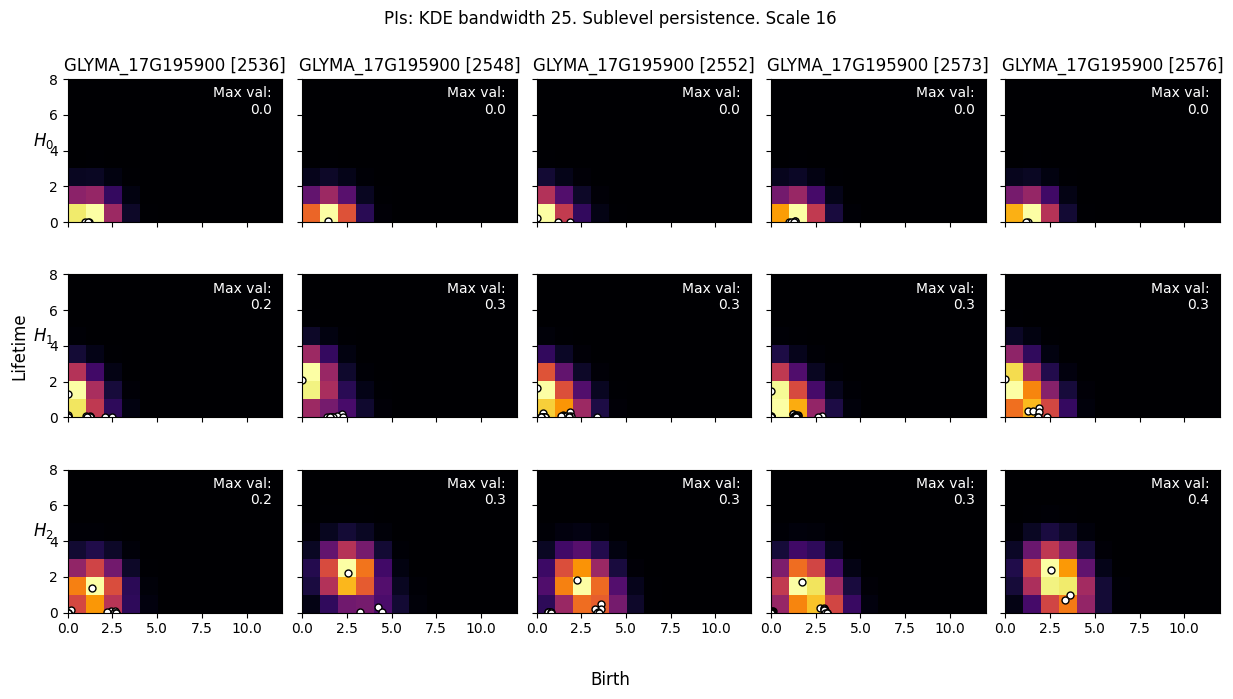

In [20]:
idx = ratios.T[ratios.T[gene] > 0 ].index[-5:].values
gs = [ ratios.index[-1] for _ in range(len(idx)) ]

fig, ax = plt.subplots(ndims, len(idx), figsize=(2.5*len(idx), 7), sharex=True, sharey=True)
#ax = np.atleast_1d(ax).ravel(); i = 0

for k in range(ndims):
    for i in range(len(idx)):
        ax[k,i].imshow(img[gs[i]][idx[i]][k].T, cmap='inferno', vmin=0, origin='lower', extent=extent)
        ax[k,i].text((extent[1] - extent[0])*.95, (extent[3] - extent[2])*.95, 
                    'Max val:\n{:.1f}'.format(np.max(img[gs[i]][idx[i]][k])), color='w', ha='right', va='top')
        foo = lt_diags[gs[i]][idx[i]][k]
        ax[k,i].scatter(foo[:,0], foo[:,1], c='w', marker='o', s=25, edgecolor='k', linewidth=1)
    ax[k,0].set_ylabel('$H_{}$'.format(k), fontsize=fs, rotation=0)

for i in range(len(idx)):
    ax[0,i].set_title('{} [{}]'.format(gs[i], idx[i]), fontsize=fs)

fig.suptitle(Bname, fontsize=fs)
fig.supxlabel('Birth', fontsize=fs)
fig.supylabel('Lifetime', fontsize=fs)
fig.tight_layout();

- Averaging all the images, one average per dimension

../infected_focus_summer24/D2/17G195900_bw25_sublevel/PI_scale16_average.png


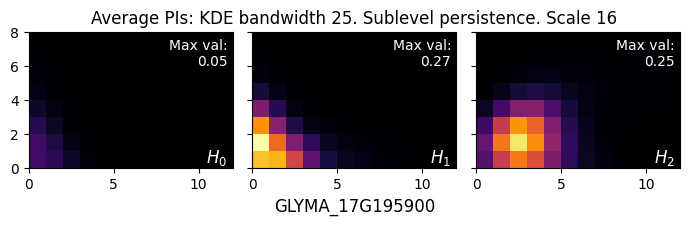

In [16]:
avg = np.zeros( (ndims, len(nzcumsum) - 1, pimgr.resolution[1], pimgr.resolution[0]))
for k in range(len(avg)):
    for i in range(avg.shape[1]):
        avg[k,i] = np.mean(pi[ k, nzcumsum[i]:nzcumsum[i+1] ], axis=0).reshape(avg.shape[3], avg.shape[2]).T
avgmax = avg.max()

fig, ax = plt.subplots(len(ratios), len(avg), figsize=(7, 2*len(ratios)), sharex=True, sharey=True)
ax = np.atleast_2d(ax)

for i in range(len(ratios)):
    for k in range(len(avg)):
        ax[i,k].text((extent[1] - extent[0])*.975, 0, '$H_{}$'.format(k), fontsize=fs, color='w', ha='right', va='bottom')
        ax[i,k].imshow(avg[k,i], cmap='inferno', origin='lower', vmin=0, vmax=avgmax, extent=extent)
        ax[i,k].text((extent[1] - extent[0])*.975, (extent[3] - extent[2])*.95, 
                     'Max val:\n{:.2f}'.format(np.max(avg[k,i])), color='w', ha='right', va='top')
    ax[i,1].set_xlabel(ratios.index[i], fontsize=fs)

ax[0,1].set_title('Average ' + Bname, fontsize=fs)
fig.tight_layout()
filename = bname + 'average.png'
print(filename)
#plt.savefig(filename, dpi=dpi, bbox_inches='tight', format='png')

# Reduce dimensions with PCA

- To avoid influence of outliers, images with extremely high values are temporarily excluded
    - Standardization and PCA is computed initially without these outlying images
    - The outlying images are then tranformed with the outlier-less model and then added back to the group
- Prior to PCA computation, data is centered but the variance is **not** normalized.
    - Normalizing variance is important when PCA has summarize descriptors that all have different scales/measurment units
    - But in this case, all our descriptors come from the exact same place and units.
 


../infected_focus_summer24/D2/17G195900_bw25_sublevel/PI_scale16_max_vals.png


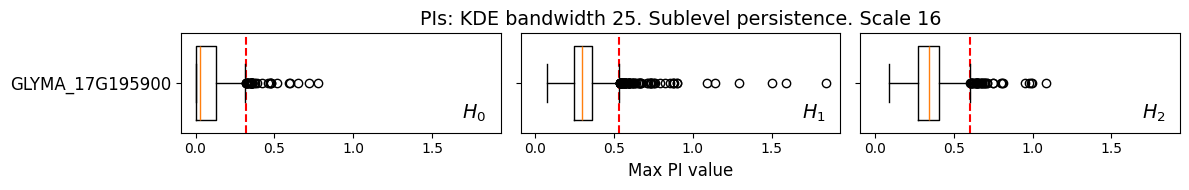

In [21]:
alpha = 0.25
maxpis = np.max(pi, axis=2)
maxxpis = maxpis.max()
boxes = [ [ maxpis[k, nzcumsum[i]:nzcumsum[i+1]] for i in range(len(nzcumsum)-1) ] for k in range(len(maxpis)) ]
qq = np.asarray([ [ np.quantile(boxes[k][i], [alpha, 1-alpha]) for i in range(len(boxes[k])) ] for k in range(len(boxes)) ])
thr = np.max(qq[:,:,1] + iqr_factor*(qq[:,:,1] - qq[:,:,0]), axis=1)


fig, ax = plt.subplots(1, len(thr), figsize=(12, max([1.25*len(ratios), 2])), sharex=True, sharey=True)
ax = np.atleast_1d(ax).ravel(); 
for k in range(len(ax)):
    ax[k].axvline(thr[k], c='r', ls='--', zorder=1)
    ax[k].boxplot(boxes[k], vert=False, zorder=2, widths=0.75)
    ax[k].text(maxxpis, 0.8, '$H_{}$'.format(k), fontsize=1.15*fs, ha='right', va='top')

ax[0].set_yticks(range(1, len(lt_diags)+1), iter(lt_diags.keys()), fontsize=fs)

ax[1].set_title(Bname, fontsize=1.15*fs)
ax[1].set_xlabel('Max PI value', fontsize=fs)
filename = tdst + bname + 'max_PI_val_boxplot'
fig.tight_layout()
filename = bname + 'max_vals.png'
print(filename)
#plt.savefig(filename, dpi=dpi, bbox_inches='tight', format='png')

In [22]:
perm = perms[2]
print(perm)
pname = 'H' + '+'.join(perm.astype(str))
Pname = ' [$' + ' \\oplus '.join(['H_{}'.format(k) for k in perm]) + '$]'
full_pi = np.hstack(pi[perm])
print(full_pi.shape)
maxmask = np.ones(len(full_pi), dtype=bool)
maxmask[functools.reduce(np.union1d, [np.nonzero(maxpis[k] > thr[k])[0] for k in perm])] = False

scaler = preprocessing.StandardScaler(copy=True, with_std=False, with_mean=True).fit(full_pi[maxmask].copy())
data = scaler.transform(full_pi[maxmask])
fulldata = scaler.transform(full_pi)

print(data.shape, fulldata.shape, np.quantile(fulldata[fulldata > 0], 0.99), sep='\n')

[1 2]
(918, 192)
(832, 192)
(918, 192)
0.43974115763741756


# Actually computing PCA

- Looking at the loadings to have a better sense of what parts of the images (and thus from the diagram) are driving up/down the PC values
- Plotting the PC values and their explained variance
- Saving the results

In [23]:
PCA = decomposition.PCA(n_components=min([6, data.shape[1]//20]), random_state=seed, svd_solver='full').fit(data)
print('Considering the first', PCA.n_components,'PCs')

pca = PCA.transform(fulldata).astype('float32')
zero_val = PCA.transform(scaler.transform(np.zeros((1,fulldata.shape[1]))))
loadings = PCA.components_.T * np.sqrt(PCA.explained_variance_)
explained_ratio = 100*PCA.explained_variance_ratio_
print(explained_ratio)
print('Total explained var:\t', np.sum(explained_ratio), np.sum(explained_ratio[:2]))

Considering the first 6 PCs
[38.63212498 27.24785364 12.10622657  7.94820834  3.11110028  2.73711123]
Total explained var:	 91.78262503938599 65.8799786182121


../infected_focus_summer24/D2/17G195900_bw25_sublevel/PI_scale16_loadings.png


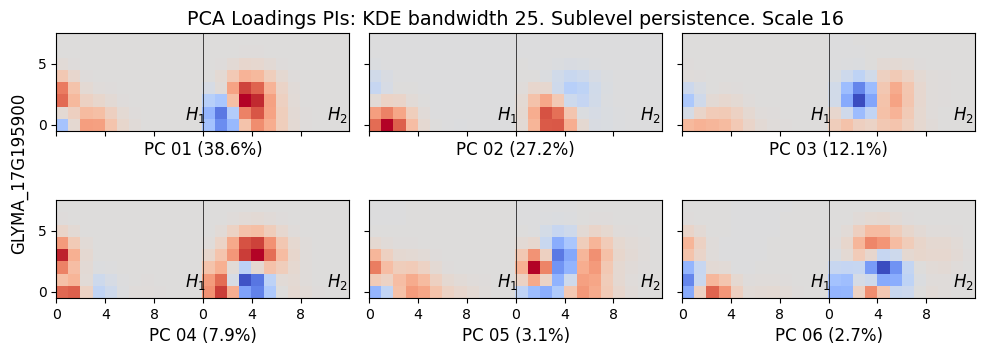

In [24]:
pcacol = 3
pcarow = np.where(pca.shape[1] % pcacol == 0, pca.shape[1]//pcacol, pca.shape[1]//pcacol + 1) + 0

xlabs = np.tile(np.arange(0, extent[1]-2, extent[1]//3), len(perm))
xticks = np.hstack([ np.arange(0, extent[1]-2, xlabs[1]-xlabs[0]) + i*extent[1] for i in range(len(perm)) ]) - 0.5

fig, ax = plt.subplots(pcarow, pcacol, figsize=(10, 2.0*pcarow), sharex=True, sharey=True)
ax = np.atleast_1d(ax).ravel(); i = 0
for i in range(loadings.shape[1]):
    ll = loadings[:,i].reshape( len(perm)*extent[1], extent[3], order='C').T
    vmax = np.max(np.abs(ll))
    ax[i].imshow(ll, cmap='coolwarm', vmax=vmax, vmin=-vmax, origin='lower')
    ax[i].set_xlabel('PC {:02d} ({:.1f}%)'.format(i+1, explained_ratio[i]), fontsize=fs)
    for j in range(1, len(perm)):
        ax[i].axvline(j*extent[1] - 0.5, c='k', lw=0.5)
    ax[i].set_xticks(xticks, xlabs, fontsize=0.85*fs)
    for k in perm:
        ax[i].text(.975*(k*extent[1]), 0, '$H_{}$'.format(k), c='k', va='bottom', ha='right', fontsize=fs)

for i in range(loadings.shape[1], len(ax)):
    fig.delaxes(ax[i])
ax[pcacol//2].set_title('PCA Loadings ' + Bname, fontsize=1.15*fs)
fig.supylabel(ratios.index[0], fontsize=fs)
fig.tight_layout();
filename = bname + 'loadings.png'
print(filename)
#plt.savefig(filename, dpi=dpi, bbox_inches='tight', format='png')

In [25]:
pcacols = ['PC {:02d} ({:.2f})'.format(i+1,explained_ratio[i]) for i in range(pca.shape[1])]
summary = bsummary.join(pd.DataFrame(pca, columns=pcacols))
summary.loc[len(summary)] = ['ZERO', 0] + zero_val[0].tolist() 
minspos = 1.2*summary[pcacols[:2]].min().values
filename = bname + 'pca.csv'
print(filename)
#summary.to_csv(filename, index=False)
summary

../infected_focus_summer24/D2/17G195900_bw25_sublevel/PI_scale16_pca.csv


,gene,ndimage_ID,PC 01 (38.63),PC 02 (27.25),PC 03 (12.11),PC 04 (7.95),PC 05 (3.11),PC 06 (2.74)
0,GLYMA_17G195900,169,0.375853,-0.131497,-0.335668,0.154221,-0.032715,0.048592
1,GLYMA_17G195900,188,0.890813,0.630507,-0.205007,0.606966,0.084701,-0.081842
2,GLYMA_17G195900,199,-0.326942,0.223153,0.121203,0.063796,-0.058198,0.016775
3,GLYMA_17G195900,209,-0.065328,-0.204464,-0.217499,-0.082403,0.050637,-0.004216
4,GLYMA_17G195900,224,0.358477,-0.125635,-0.220705,0.039222,-0.014360,-0.038178
...,...,...,...,...,...,...,...,...
914,GLYMA_17G195900,2548,0.041217,-0.123974,-0.230093,-0.078622,0.060811,0.001684
915,GLYMA_17G195900,2552,-0.128697,0.078980,-0.033329,-0.061017,0.012019,0.022614
916,GLYMA_17G195900,2573,-0.290698,0.039899,0.050918,0.026807,0.012267,0.008344
917,GLYMA_17G195900,2576,0.196644,0.287561,-0.229504,-0.055214,0.026843,-0.014159


../infected_focus_summer24/D2/17G195900_bw25_sublevel/PI_scale16_pca_H1+2


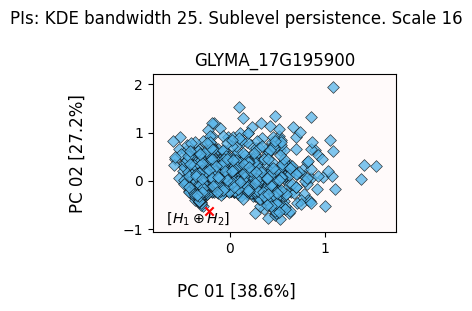

In [26]:
nrows = 1
ncols = len(ratios)//nrows
fig, ax = plt.subplots(nrows, ncols, figsize=(3.5*ncols,2*nrows+1), sharex=True, sharey=True)
ax = np.atleast_1d(ax).ravel()

for i in range(len(ax)):
    gene = ratios.index[i]
    ax[i].set_facecolor('snow')
    ax[i].scatter(*summary.loc[ summary['gene'] != gene, pcacols[:2] ].T.values, c='lightgray', marker='.', s=1, alpha=1, zorder=1)
    ax[i].scatter(*summary.loc[ summary['gene'] == gene, pcacols[:2] ].T.values, c=color[i], marker=marker[i], alpha=0.75, zorder=2,
                  edgecolor='k', linewidth=0.5)
    ax[i].set_title(gene)
    ax[i].text(*minspos, Pname, ha='left', va='bottom', fontsize=0.85*fs)
    ax[i].margins(0.1)
    ax[i].scatter(zero_val[0,0], zero_val[0,1], c='r', marker='x', zorder=3)

for i in range( len(ax) - len(nzcumsum)+1 , 0, -1):
    fig.delaxes(ax[-i])

fig.suptitle(Bname, fontsize=fs)
fig.supxlabel('PC 01 [{:.1f}%]'.format(explained_ratio[0]), fontsize=fs)
fig.supylabel('PC 02 [{:.1f}%]'.format(explained_ratio[1]), fontsize=fs)

fig.tight_layout();
filename = bname + 'pca_' + pname
print(filename)
#plt.savefig(filename + '.png', dpi=dpi, bbox_inches='tight', format='png')

# KPCA and other dimension reduction techniques

Since Persistence Images are ultimately vectors, they can be fed to other well-established dimension reduction algorithms. None of the ones below were explored in detail.

While algorithms like non-linear kernel PCA, isomap, local linear embeddings, tSNE, and others offer more powerful dimension reduction and structure preserving techniques, they are much more difficult to track. The meaning of PC1 and PC2 can be tracked back with the loadings, and the variance captured by them can be easily determined. In principle, we can go back to the raw data and understand why PCA summarized the data the way it did.

The meaning of, say, UMAP1 and UMAP2 is much more difficult to assertain. By comparing the raw data to the UMAP result, we only have an informed guess at best.

In [33]:
def plot_embedding(embedding, alpha=0.05, title=None, nrows=2, ncols=4):
    q1, q3 = np.quantile(embedding[:,:2], [alpha, 1-alpha], axis=0)
    iqr = q3 - q1
    mn = np.maximum( q1 - 1.5*iqr, np.min(embedding[:,:2], axis=0) )
    mx = np.minimum( q3 + 1.5*iqr, np.max(embedding[:,:2], axis=0) )
        
    fig, ax = plt.subplots(nrows, ncols, figsize=(4*ncols+1,3*nrows+1), sharex=True, sharey=True)
    ax = np.atleast_1d(ax).ravel()
    
    for i in range(len(nzcumsum) - 1):
        ax[i].scatter(embedding[:,0], embedding[:,1], c='lightgray', marker='.', s=1, alpha=1, zorder=1)
        ax[i].set_facecolor('snow')
        s_ = np.s_[nzcumsum[i]:nzcumsum[i+1]]
        ax[i].scatter(embedding[s_,0], embedding[s_,1], c=color[i], marker=marker[i], alpha=0.75, zorder=2,
                      edgecolor='k', linewidth=0.5)
        ax[i].set_title(transcriptomes[Genes[i]])
        ax[i].set_xlim(mn[0],mx[0]);ax[0].set_ylim(mn[1],mx[1])
        #ax[i].tick_params(left=False, labelleft=False, labelbottom=False, bottom=False);
    
    for i in range( len(ax) - len(nzcumsum)+1 , 0, -1):
        fig.delaxes(ax[-i])

    if title is not None:
        fig.supxlabel(title + ' 01')
        fig.supylabel(title + ' 02')
    
    return fig, ax

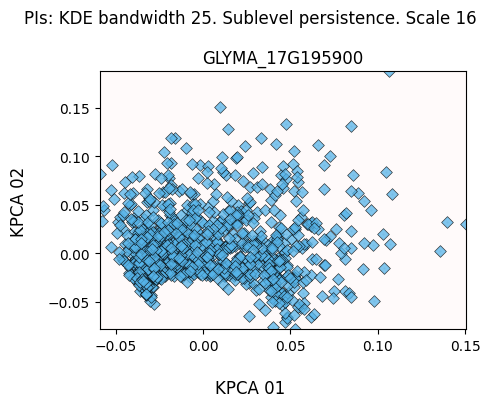

In [34]:
params = {'kernel':'rbf', 'gamma':0.005}
#params = {'kernel':'poly', 'gamma':0.1, 'degree':3}
#params = {'kernel':'sigmoid', 'gamma':0.1}

KPCA = decomposition.KernelPCA(n_components=2, **params)
KPCA.fit(data)
kpca = KPCA.transform(fulldata).astype('float32')

fig, ax = plot_embedding(kpca, 0.0, 'KPCA', nrows=nrows, ncols=ncols)
fig.suptitle(Bname)
fig.tight_layout();

# Locally Linear Embeddings

In [35]:
import umap
from sklearn import decomposition, preprocessing, manifold

In [36]:
method = 'LLE'
n_neighbors = 24  # neighborhood which is used to recover the locally linear structure
params = {"n_neighbors": n_neighbors,"n_components": 2, "eigen_solver": "auto","random_state": seed}
LLE = manifold.LocallyLinearEmbedding(method="standard", **params)
LLE.fit(data)
lle = LLE.transform(fulldata).astype('float32')
params = LLE.get_params()

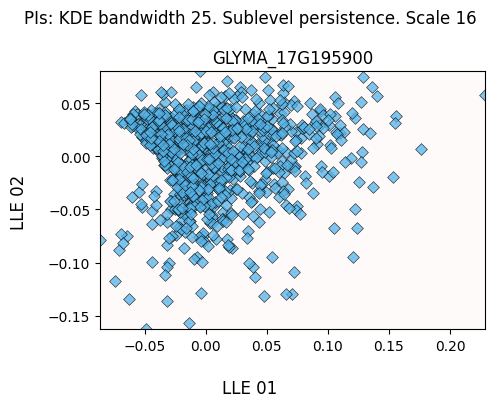

In [38]:
fig, ax = plot_embedding(lle, 0.0, method, nrows=nrows, ncols=ncols)
fig.suptitle(Bname)
fig.tight_layout();
filename = tdst + bname + '{}_{}_{}'.format(method.lower(), LLE.method, params['n_neighbors']) + '_' + pname
#plt.savefig(filename + '.png', dpi=dpi, bbox_inches='tight', format='png')

# Isomap

In [46]:
method = 'ISO'
n_neighbors = 16  # neighborhood which is used to recover the locally linear structure
params = {"n_neighbors": n_neighbors,"n_components": 2,"eigen_solver": "auto"}
ISO = manifold.Isomap(**params)
ISO.fit(data)
iso = ISO.transform(fulldata).astype('float32')
params = ISO.get_params()
ISO.reconstruction_error()

0.08116983497704422

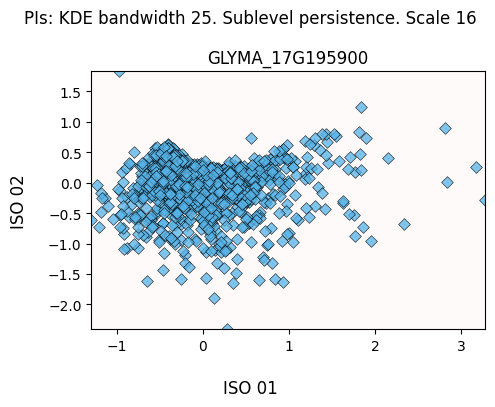

In [48]:
fig, ax = plot_embedding(iso, 0.0, method, nrows=nrows, ncols=ncols)
fig.suptitle(Bname)
fig.tight_layout();
filename = tdst + bname + '{}_{}.csv'.format(method.lower(), params['n_neighbors'])
#plt.savefig(filename + '.png', dpi=dpi, bbox_inches='tight', format='png')

# tSNE

In [49]:
method = 'tSNE'
t_sne = manifold.TSNE(
    n_components=2,
    perplexity=25,
    init="random",
    n_iter=250,
    random_state=seed,
)
tsne = t_sne.fit_transform(fulldata).astype('float32')
params = t_sne.get_params()

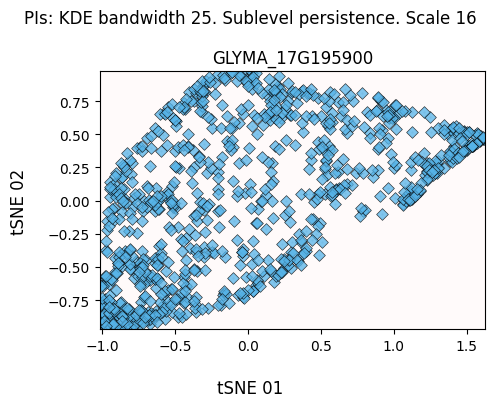

In [50]:
fig, ax = plot_embedding(tsne, 0.0, method, nrows=nrows, ncols=ncols)
fig.suptitle(Bname)
fig.tight_layout();
filename = tdst + bname + '{}_{}.csv'.format(method.lower(), params['perplexity'])
#plt.savefig(filename + '.png', dpi=dpi, bbox_inches='tight', format='png')

# UMAP

In [51]:
method = 'UMAP'
ufit = umap.UMAP(n_neighbors=10, min_dist=0.25, n_components=2, metric='euclidean', random_state=seed, n_jobs=1)
u_umap = ufit.fit_transform(fulldata);
params = ufit.get_params();

/home/eah4d/.local/lib/python3.10/site-packages/numba/np/ufunc/parallel.py:371: NumbaWarning: The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12050. The TBB threading layer is disabled.
  warnings.warn(problem)


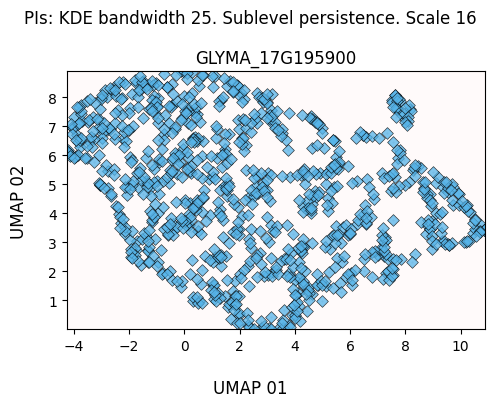

In [52]:
fig, ax = plot_embedding(u_umap, 0.0, method, nrows=nrows, ncols=ncols)
fig.suptitle(Bname)
fig.tight_layout();
filename = tdst + bname + '{}_{}_{}_{}_{}'.format(method.lower(), params['n_neighbors'], params['min_dist'],params['metric'],params['n_components'])
#plt.savefig(filename + '.png', dpi=dpi, bbox_inches='tight', format='png')